In [59]:
from moexalgo import Market, Ticker
import pandas as pd
import backtrader as bt
import backtrader.feeds as btfeeds
import datetime
import numpy as np
import backtrader.analyzers as btanalyzers
import math
import matplotlib.pyplot as plt
from functools import partial

In [42]:
ticker = 'KZOS'
algopack_ticker = Ticker(ticker)

ticker_tradestats = pd.concat(
    [algopack_ticker.tradestats(date='2022-01-01', till_date='2022-12-30'),
     algopack_ticker.tradestats(date='2022-12-31', till_date='2023-12-16')], ignore_index=True)

ticker_orderstats = pd.concat(
    [algopack_ticker.orderstats(date='2022-01-01', till_date='2022-12-30'),
     algopack_ticker.orderstats(date='2022-12-31', till_date='2023-12-16')], ignore_index=True)

ticker_tradestats['tradedate'] = ticker_tradestats['tradedate'].astype(str) + ' ' + ticker_tradestats['tradetime'].astype(str)
ticker_orderstats['tradedate'] = ticker_orderstats['tradedate'].astype(str) + ' ' + ticker_orderstats['tradetime'].astype(str)

ticker_stats = pd.merge(ticker_tradestats, ticker_orderstats, on='tradedate', how='inner')

ticker_stats = ticker_stats[['tradedate', 'put_orders_b', 'put_orders_s', 'put_vol_b', 
                       'put_vol_s', 'pr_open', 'pr_high', 'pr_low', 'pr_close', 'vol', 'pr_vwap']]

ticker_stats.to_csv(f'{ticker}.csv', index=False)

In [35]:
class MyCSVData(btfeeds.GenericCSVData):
    lines = ('pr_vwap', 'put_orders_b', 'put_orders_s', 'put_vol_b', 'put_vol_s',)
    params = (
    ('fromdate', datetime.datetime(2022, 1, 3)),
    ('todate', datetime.datetime(2023, 12, 8)),
    ('timeframe', bt.TimeFrame.Minutes),
    ('nullvalue', 0.0),
    ('dtformat', ('%Y-%m-%d %H:%M:%S')),
    
    ('datetime', 0),
    ('put_orders_b', 1),
    ('put_orders_s', 2),
    ('put_vol_b', 3),
    ('put_vol_s', 4),
    ('open', 5),
    ('high', 6),
    ('low', 7),
    ('close', 8),
    ('volume', 9),
    ('pr_vwap', 10),
    ('openinterest', -1)
)

In [108]:
class EMA_Breakthrough_v1(bt.Strategy):
    
    def __init__(self):
        self.sma = bt.ind.EMA(period=200)
        self.up_flag = None
        self.wait_flag = False
        self.n_wait = 5
        self.cur_i_candle = 0 
        self.order = None
        self.order_counter = 0
        self.volumes = []
        self.quantile = 0.8
        self.quantile_n_vols = 2000
        
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {self.datas[0].datetime.time(0).isoformat()} {txt}') # Comment this line when running optimization
        print('Количество ордеров:', self.order_counter)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        self.order_counter += 1
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, {order.executed.price:.2f} {order.executed.size}')
            elif order.issell():
                self.log(f'SELL EXECUTED, {order.executed.price:.2f} {order.executed.size}')
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Reset orders
        self.order = None
        
        
    def next(self):
        item = self.datas[0]
        if len(self.volumes) > self.quantile_n_vols:
            self.volumes[:-1] = self.volumes[1:]
            self.volumes[-1] = item.volume[0]
        else:
            self.volumes.append(item.volume[0])
            return
        
        if self.wait_flag:
            if (self.up_flag and item.pr_vwap[0] >= self.sma)\
                    or (not self.up_flag and item.pr_vwap[0] < self.sma):
                self.cur_i_candle += 1
            else:
                self.wait_flag = False
                self.up_flag = not self.up_flag
            
            if self.cur_i_candle == self.n_wait:
                
                if self.up_flag:
                    if self.position.size < 0:
                        print('Closing', self.position.size)
                        self.order = self.close()
                    print('Buying', self.position.size)
                    size = math.floor(self.broker.cash / 10 / self.data.close)
                    self.order = self.buy(size=size)
                elif not self.up_flag:
                    if self.position.size > 0:
                        print('Closing', self.position.size)
                        self.order = self.close()
                    print('Selling', self.position.size)
                    size = math.floor(self.broker.cash / 10 / self.data.close)
                    self.order = self.sell(size=size)
                self.wait_flag = False
            

        else:
            if (not self.up_flag and item.pr_vwap[0] >= self.sma) \
                    or (self.up_flag and item.pr_vwap[0] < self.sma):
                self.up_flag = not self.up_flag
                temp_vol_list = np.array([item.volume[-3], item.volume[-2], item.volume[-1]])
                if temp_vol_list.mean() > np.quantile(self.volumes, self.quantile):
                    self.wait_flag = True
                    start_price = item.close[0]
                    self.cur_i_candle = 0

In [109]:
cerebro = bt.Cerebro()
cerebro.broker.set_cash(1000000.0)

ticker = 'SMLT'
data = MyCSVData(dataname=f'{ticker}.csv')
cerebro.adddata(data)

cerebro.addstrategy(EMA_Breakthrough_v1)

cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe', riskfreerate=0.11)
cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')

thestrats = cerebro.run()
thestrat = thestrats[0]

print('Sharpe Ratio:', thestrat.analyzers.mysharpe.get_analysis())
print('Max drawdown:', thestrat.analyzers.drawdown.get_analysis().max)

Buying 0
2022-02-03 11:35:00 BUY EXECUTED, 4504.00 22
Количество ордеров: 1
Closing 22
Selling 22
2022-02-03 13:55:00 SELL EXECUTED, 4423.00 -22
Количество ордеров: 2
2022-02-03 13:55:00 SELL EXECUTED, 4423.00 -20
Количество ордеров: 3
Closing -20
Buying -20
2022-02-03 14:35:00 BUY EXECUTED, 4460.00 20
Количество ордеров: 4
2022-02-03 14:35:00 BUY EXECUTED, 4460.00 24
Количество ордеров: 5
Buying 24
2022-02-04 10:55:00 BUY EXECUTED, 4470.00 19
Количество ордеров: 6
Buying 43
2022-02-08 11:40:00 BUY EXECUTED, 4476.50 17
Количество ордеров: 7
Buying 60
2022-02-18 10:55:00 BUY EXECUTED, 4590.00 15
Количество ордеров: 8
Buying 75
2022-03-30 12:10:00 BUY EXECUTED, 2480.00 26
Количество ордеров: 9
Closing 101
Selling 101
2022-03-30 13:35:00 SELL EXECUTED, 2413.50 -101
Количество ордеров: 10
2022-03-30 13:35:00 SELL EXECUTED, 2413.50 -24
Количество ордеров: 11
Closing -24
Buying -24
2022-03-31 10:30:00 BUY EXECUTED, 2750.00 24
Количество ордеров: 12
2022-03-31 10:30:00 BUY EXECUTED, 2750.00 3

Selling -60
2023-02-21 10:40:00 SELL EXECUTED, 2524.00 -41
Количество ордеров: 109
Selling -101
2023-02-21 11:40:00 SELL EXECUTED, 2523.00 -45
Количество ордеров: 110
Closing -146
Buying -146
2023-02-21 13:00:00 BUY EXECUTED, 2662.00 146
Количество ордеров: 111
2023-02-21 13:00:00 BUY EXECUTED, 2662.00 47
Количество ордеров: 112
Closing 47
Selling 47
2023-02-21 18:35:00 SELL EXECUTED, 2545.00 -47
Количество ордеров: 113
2023-02-21 18:35:00 SELL EXECUTED, 2545.00 -29
Количество ордеров: 114
Selling -29
2023-02-22 10:50:00 SELL EXECUTED, 2546.50 -37
Количество ордеров: 115
Closing -66
Buying -66
2023-02-27 10:50:00 BUY EXECUTED, 2589.50 66
Количество ордеров: 116
2023-02-27 10:50:00 BUY EXECUTED, 2589.50 40
Количество ордеров: 117
Closing 40
Selling 40
2023-03-02 10:40:00 SELL EXECUTED, 2580.00 -40
Количество ордеров: 118
2023-03-02 10:40:00 SELL EXECUTED, 2580.00 -29
Количество ордеров: 119
Closing -29
Buying -29
2023-03-13 10:50:00 BUY EXECUTED, 2566.50 29
Количество ордеров: 120
2023-

<IPython.core.display.Javascript object>


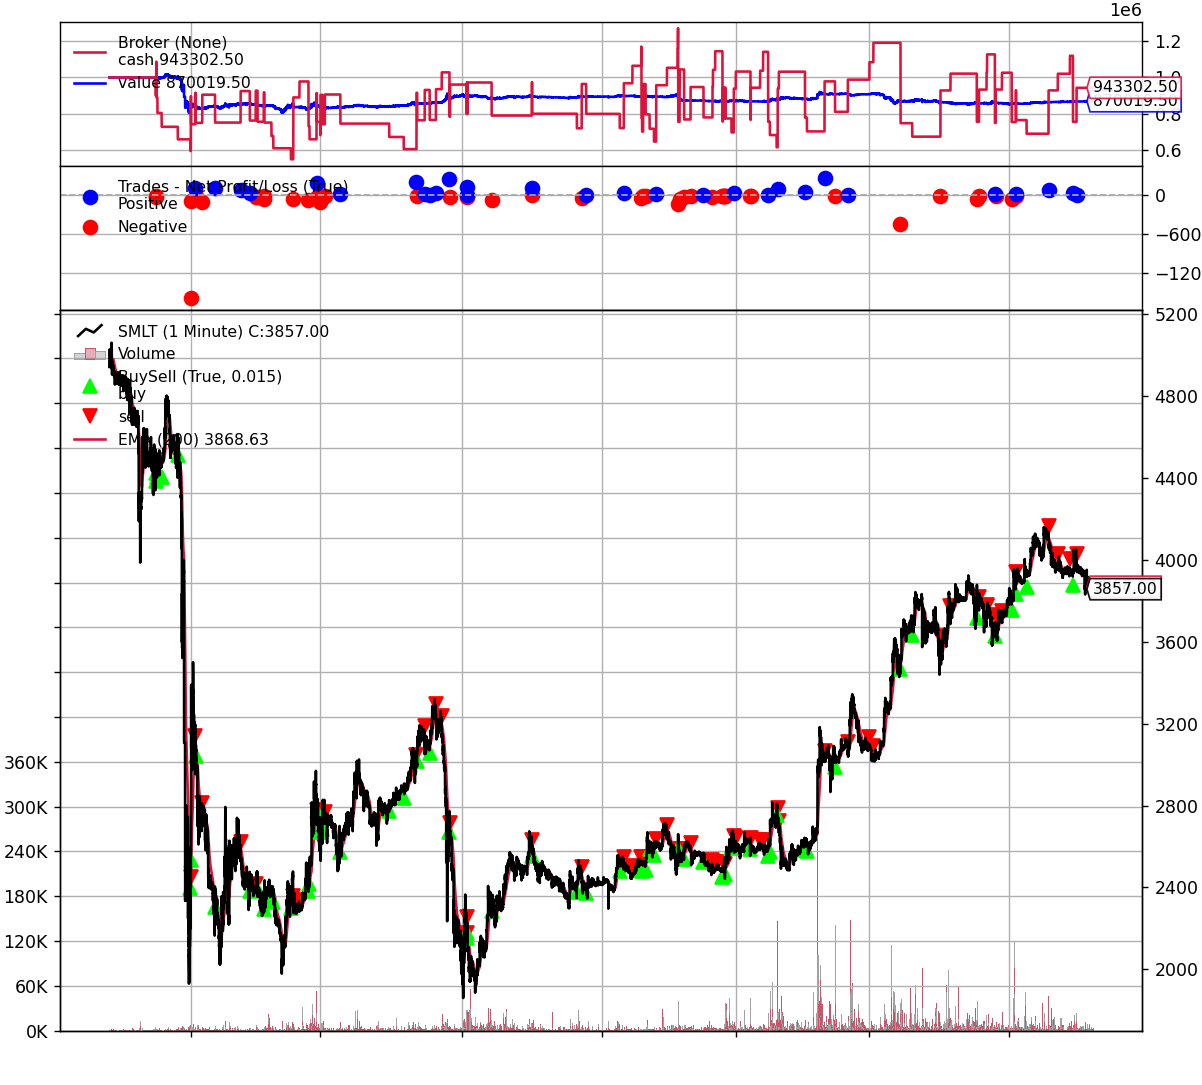

[[<Figure size 640x480 with 4 Axes>]]

In [110]:
cerebro.plot()

In [115]:
cerebro = bt.Cerebro()
cerebro.broker.set_cash(1000000.0)

ticker = 'SBER'
data = MyCSVData(dataname=f'{ticker}.csv')
cerebro.adddata(data)

cerebro.addstrategy(EMA_Breakthrough_v1)

cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe', riskfreerate=0.11)
cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')

thestrats = cerebro.run()
thestrat = thestrats[0]

print('Sharpe Ratio:', thestrat.analyzers.mysharpe.get_analysis())
print('Max drawdown:', thestrat.analyzers.drawdown.get_analysis().max)

Buying 0
2022-02-22 18:20:00 BUY EXECUTED, 215.70 463
Количество ордеров: 1
Closing 463
Selling 463
2022-02-24 10:40:00 SELL EXECUTED, 150.14 -463
Количество ордеров: 2
2022-02-24 10:40:00 SELL EXECUTED, 150.14 -599
Количество ордеров: 3
Closing -599
Buying -599
2022-03-24 10:45:00 BUY EXECUTED, 150.76 599
Количество ордеров: 4
2022-03-24 10:45:00 BUY EXECUTED, 150.76 702
Количество ордеров: 5
Closing 702
Selling 702
2022-03-25 10:40:00 SELL EXECUTED, 131.89 -702
Количество ордеров: 6
2022-03-25 10:40:00 SELL EXECUTED, 131.89 -654
Количество ордеров: 7
Closing -654
Buying -654
2022-04-22 10:55:00 BUY EXECUTED, 122.06 654
Количество ордеров: 8
2022-04-22 10:55:00 BUY EXECUTED, 122.06 853
Количество ордеров: 9
Closing 853
Selling 853
2022-04-28 15:35:00 SELL EXECUTED, 126.18 -853
Количество ордеров: 10
2022-04-28 15:35:00 SELL EXECUTED, 126.18 -680
Количество ордеров: 11
Selling -680
2022-04-29 12:45:00 SELL EXECUTED, 125.38 -838
Количество ордеров: 12
Selling -1518
2022-05-04 11:15:00 S

Closing 543
Selling 543
2023-10-20 11:05:00 SELL EXECUTED, 267.51 -543
Количество ордеров: 102
2023-10-20 11:05:00 SELL EXECUTED, 267.51 -345
Количество ордеров: 103
Closing -345
Buying -345
2023-10-24 10:55:00 BUY EXECUTED, 270.36 345
Количество ордеров: 104
2023-10-24 10:55:00 BUY EXECUTED, 270.36 429
Количество ордеров: 105
Closing 429
Selling 429
2023-10-26 14:40:00 SELL EXECUTED, 272.85 -429
Количество ордеров: 106
2023-10-26 14:40:00 SELL EXECUTED, 272.85 -349
Количество ордеров: 107
Closing -349
Buying -349
2023-10-30 11:05:00 BUY EXECUTED, 270.79 349
Количество ордеров: 108
2023-10-30 11:05:00 BUY EXECUTED, 270.79 430
Количество ордеров: 109
Closing 430
Selling 430
2023-12-01 10:45:00 SELL EXECUTED, 275.50 -430
Количество ордеров: 110
2023-12-01 10:45:00 SELL EXECUTED, 275.50 -346
Количество ордеров: 111
Selling -346
2023-12-06 11:30:00 SELL EXECUTED, 273.63 -426
Количество ордеров: 112
Sharpe Ratio: OrderedDict([('sharperatio', -35.09931231477063)])
Max drawdown: AutoOrderedDi

<IPython.core.display.Javascript object>


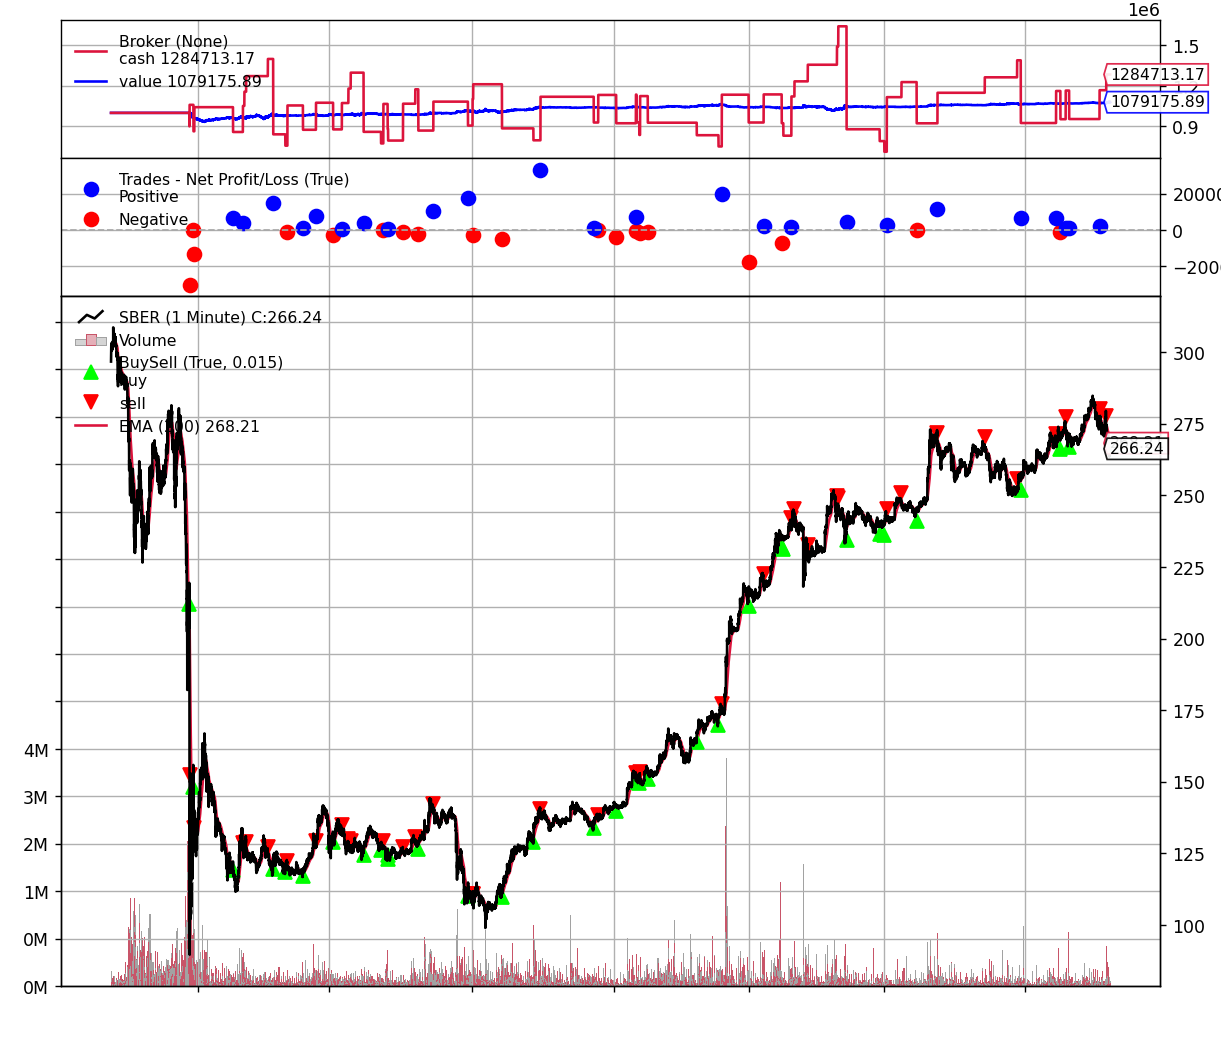

[[<Figure size 640x480 with 4 Axes>]]

In [116]:
cerebro.plot()

In [117]:
cerebro = bt.Cerebro()
cerebro.broker.set_cash(1000000.0)

ticker = 'KZOS'
data = MyCSVData(dataname=f'{ticker}.csv')
cerebro.adddata(data)

cerebro.addstrategy(EMA_Breakthrough_v1)

cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe', riskfreerate=0.11)
cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')

thestrats = cerebro.run()
thestrat = thestrats[0]

print('Sharpe Ratio:', thestrat.analyzers.mysharpe.get_analysis())
print('Max drawdown:', thestrat.analyzers.drawdown.get_analysis().max)

Selling 0
2022-02-16 17:35:00 SELL EXECUTED, 88.50 -1128
Количество ордеров: 1
Closing -1128
Buying -1128
2022-02-18 13:55:00 BUY EXECUTED, 88.70 1128
Количество ордеров: 2
2022-02-18 13:55:00 BUY EXECUTED, 88.70 1248
Количество ордеров: 3
Buying 1248
2022-02-22 18:10:00 BUY EXECUTED, 84.50 1052
Количество ордеров: 4
Buying 2300
2022-02-25 11:05:00 BUY EXECUTED, 76.60 1043
Количество ордеров: 5
Buying 3343
2022-02-25 17:00:00 BUY EXECUTED, 72.50 993
Количество ордеров: 6
Buying 4336
2022-02-25 18:35:00 BUY EXECUTED, 72.60 892
Количество ордеров: 7
Buying 5228
2022-04-20 10:50:00 BUY EXECUTED, 71.30 819
Количество ордеров: 8
Buying 6047
2022-04-26 18:10:00 BUY EXECUTED, 71.10 736
Количество ордеров: 9
Buying 6783
2022-05-17 10:35:00 BUY EXECUTED, 66.50 712
Количество ордеров: 10
Closing 7495
Selling 7495
2022-05-20 17:35:00 SELL EXECUTED, 72.70 -7495
Количество ордеров: 11
2022-05-20 17:35:00 SELL EXECUTED, 72.70 -586
Количество ордеров: 12
Selling -586
2022-05-23 10:15:00 SELL EXECUTED

Selling -7929
2023-03-31 14:00:00 SELL EXECUTED, 102.70 -1703
Количество ордеров: 110
Selling -9632
2023-04-05 18:10:00 SELL EXECUTED, 105.00 -1837
Количество ордеров: 111
Closing -11469
Buying -11469
2023-04-19 10:35:00 BUY EXECUTED, 107.00 11469
Количество ордеров: 112
2023-04-19 10:35:00 BUY EXECUTED, 107.00 1978
Количество ордеров: 113
Closing 1978
Selling 1978
2023-04-19 13:10:00 SELL EXECUTED, 106.50 -1978
Количество ордеров: 114
2023-04-19 13:10:00 SELL EXECUTED, 106.50 -638
Количество ордеров: 115
Selling -638
2023-04-25 12:00:00 SELL EXECUTED, 103.90 -923
Количество ордеров: 116
Selling -1561
2023-05-12 10:50:00 SELL EXECUTED, 100.70 -1045
Количество ордеров: 117
Selling -2606
2023-05-22 13:45:00 SELL EXECUTED, 106.80 -1085
Количество ордеров: 118
Selling -3691
2023-05-23 16:25:00 SELL EXECUTED, 103.80 -1228
Количество ордеров: 119
Selling -4919
2023-05-25 11:00:00 SELL EXECUTED, 106.00 -1324
Количество ордеров: 120
Closing -6243
Buying -6243
2023-06-02 10:45:00 BUY EXECUTED, 

<IPython.core.display.Javascript object>


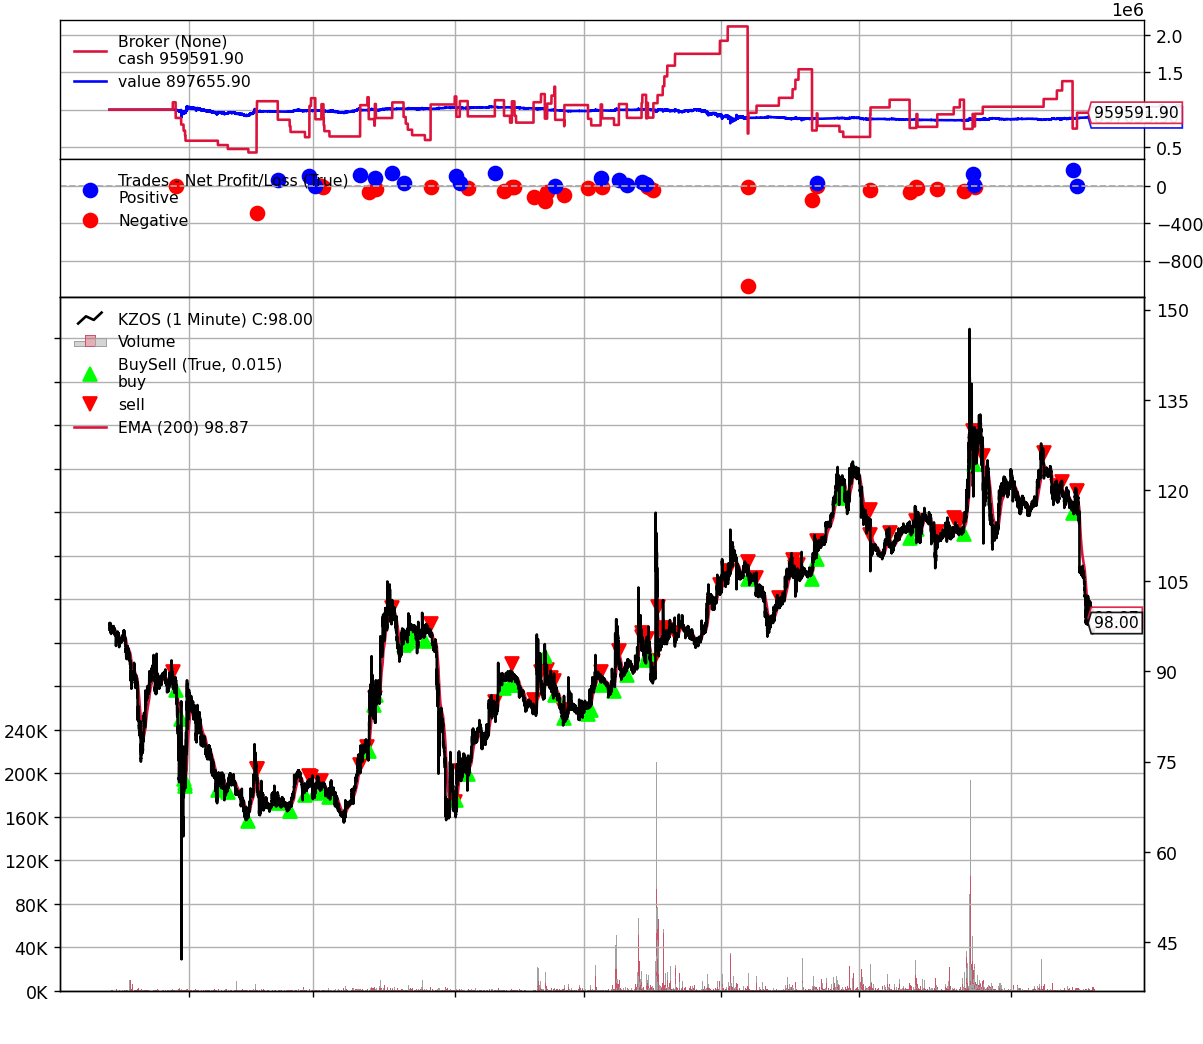

[[<Figure size 640x480 with 4 Axes>]]

In [118]:
cerebro.plot()

In [119]:
class EMA_Breakthrough_v2(bt.Strategy):
    
    def __init__(self):
        self.sma = bt.ind.EMA(period=200)
        self.up_flag = None
        self.wait_flag = False
        self.n_wait = 5
        self.cur_i_candle = 0 
        self.order = None
        self.order_counter = 0
        self.volumes = []
        self.quantile = 0.8
        self.quantile_n_vols = 2000
        self.limit_change = 0.01
        
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {self.datas[0].datetime.time(0).isoformat()} {txt}') # Comment this line when running optimization
        print('Количество ордеров:', self.order_counter)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        self.order_counter += 1
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, {order.executed.price:.2f} {order.executed.size}')
            elif order.issell():
                self.log(f'SELL EXECUTED, {order.executed.price:.2f} {order.executed.size}')
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None
        
        
    def next(self):
        item = self.datas[0]
        if len(self.volumes) > self.quantile_n_vols:
            self.volumes[:-1] = self.volumes[1:]
            self.volumes[-1] = item.volume[0]
        else:
            self.volumes.append(item.volume[0])
            return
        
        if self.wait_flag:
            if (self.up_flag and item.pr_vwap[0] >= self.sma)\
                    or (not self.up_flag and item.pr_vwap[0] < self.sma):
                self.cur_i_candle += 1
            else:
                self.wait_flag = False
                self.up_flag = not self.up_flag
            
            if self.cur_i_candle == self.n_wait:
                
                if self.up_flag:
                    if self.position.size < 0:
                        print('Closing', self.position.size)
                        self.order = self.close()
                    if item.close[0] / self.start_price < 1 + self.limit_change:
                        print('Buying', self.position.size)
                        size = math.floor(self.broker.cash / 10 / self.data.close)
                        self.order = self.buy(size=size)
                        
                    else:
                        print(f'item.close[0] / start_price = {item.close[0] / self.start_price}')
                elif not self.up_flag: 
                    if self.position.size > 0:
                        print('Closing', self.position.size)
                        self.order = self.close()
                    if item.close[0] / self.start_price > 1 - self.limit_change:
                        print('Selling', self.position.size)
                        size = math.floor(self.broker.cash / 10 / self.data.close)
                        self.order = self.sell(size=size)
                    else:
                        print(f'item.close[0] / start_price = {item.close[0] / self.start_price}')
                self.wait_flag = False
            

        else:
            if (not self.up_flag and item.pr_vwap[0] >= self.sma) \
                    or (self.up_flag and item.pr_vwap[0] < self.sma):
                self.up_flag = not self.up_flag
                vol = np.array([item.volume[-3], item.volume[-2], item.volume[-1]]).mean()

                if vol > np.quantile(self.volumes, self.quantile):
                    self.wait_flag = True
                    self.start_price = item.close[-1]
                    self.cur_i_candle = 0
            

In [120]:
cerebro = bt.Cerebro()
cerebro.broker.set_cash(1000000.0)

ticker = 'SMLT'
data = MyCSVData(dataname=f'{ticker}.csv')
cerebro.adddata(data)

cerebro.addstrategy(EMA_Breakthrough_v2)

cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe', riskfreerate=0.11)
cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')

thestrats = cerebro.run()
thestrat = thestrats[0]

print('Sharpe Ratio:', thestrat.analyzers.mysharpe.get_analysis())
print('Max drawdown:', thestrat.analyzers.drawdown.get_analysis().max)

item.close[0] / start_price = 1.0287802649611695
Selling 0
2022-02-03 13:55:00 SELL EXECUTED, 4423.00 -22
Количество ордеров: 1
Closing -22
Buying -22
2022-02-03 14:35:00 BUY EXECUTED, 4460.00 22
Количество ордеров: 2
2022-02-03 14:35:00 BUY EXECUTED, 4460.00 24
Количество ордеров: 3
item.close[0] / start_price = 1.0102836478698158
Buying 24
2022-02-08 11:40:00 BUY EXECUTED, 4476.50 19
Количество ордеров: 4
item.close[0] / start_price = 1.0313412716243542
item.close[0] / start_price = 1.0348424786146464
Closing 43
item.close[0] / start_price = 0.9709032127702566
2022-03-30 13:35:00 SELL EXECUTED, 2413.50 -43
Количество ордеров: 5
item.close[0] / start_price = 1.1386118038237738
Selling 0
2022-04-04 11:15:00 SELL EXECUTED, 3083.50 -29
Количество ордеров: 6
Closing -29
item.close[0] / start_price = 1.0103778174152749
2022-04-04 11:45:00 BUY EXECUTED, 3115.00 29
Количество ордеров: 7
Selling 0
2022-04-07 12:30:00 SELL EXECUTED, 2756.00 -33
Количество ордеров: 8
Closing -33
item.close[0] /

Closing -116
Buying -116
2023-04-24 10:50:00 BUY EXECUTED, 2593.00 116
Количество ордеров: 97
2023-04-24 10:50:00 BUY EXECUTED, 2593.00 47
Количество ордеров: 98
Buying 47
2023-04-24 17:55:00 BUY EXECUTED, 2611.50 30
Количество ордеров: 99
item.close[0] / start_price = 1.0299797682545522
Closing 77
Selling 77
2023-04-28 14:40:00 SELL EXECUTED, 2747.00 -77
Количество ордеров: 100
2023-04-28 14:40:00 SELL EXECUTED, 2747.00 -26
Количество ордеров: 101
item.close[0] / start_price = 0.9764512595837898
Closing -26
Buying -26
2023-05-19 11:50:00 BUY EXECUTED, 2623.00 26
Количество ордеров: 102
2023-05-19 11:50:00 BUY EXECUTED, 2623.00 38
Количество ордеров: 103
Buying 38
2023-05-22 10:55:00 BUY EXECUTED, 2616.50 32
Количество ордеров: 104
Closing 70
Selling 70
2023-06-01 12:30:00 SELL EXECUTED, 3016.50 -70
Количество ордеров: 105
2023-06-01 12:30:00 SELL EXECUTED, 3016.50 -24
Количество ордеров: 106
Closing -24
Buying -24
2023-06-08 11:20:00 BUY EXECUTED, 3036.50 24
Количество ордеров: 107
20

<IPython.core.display.Javascript object>


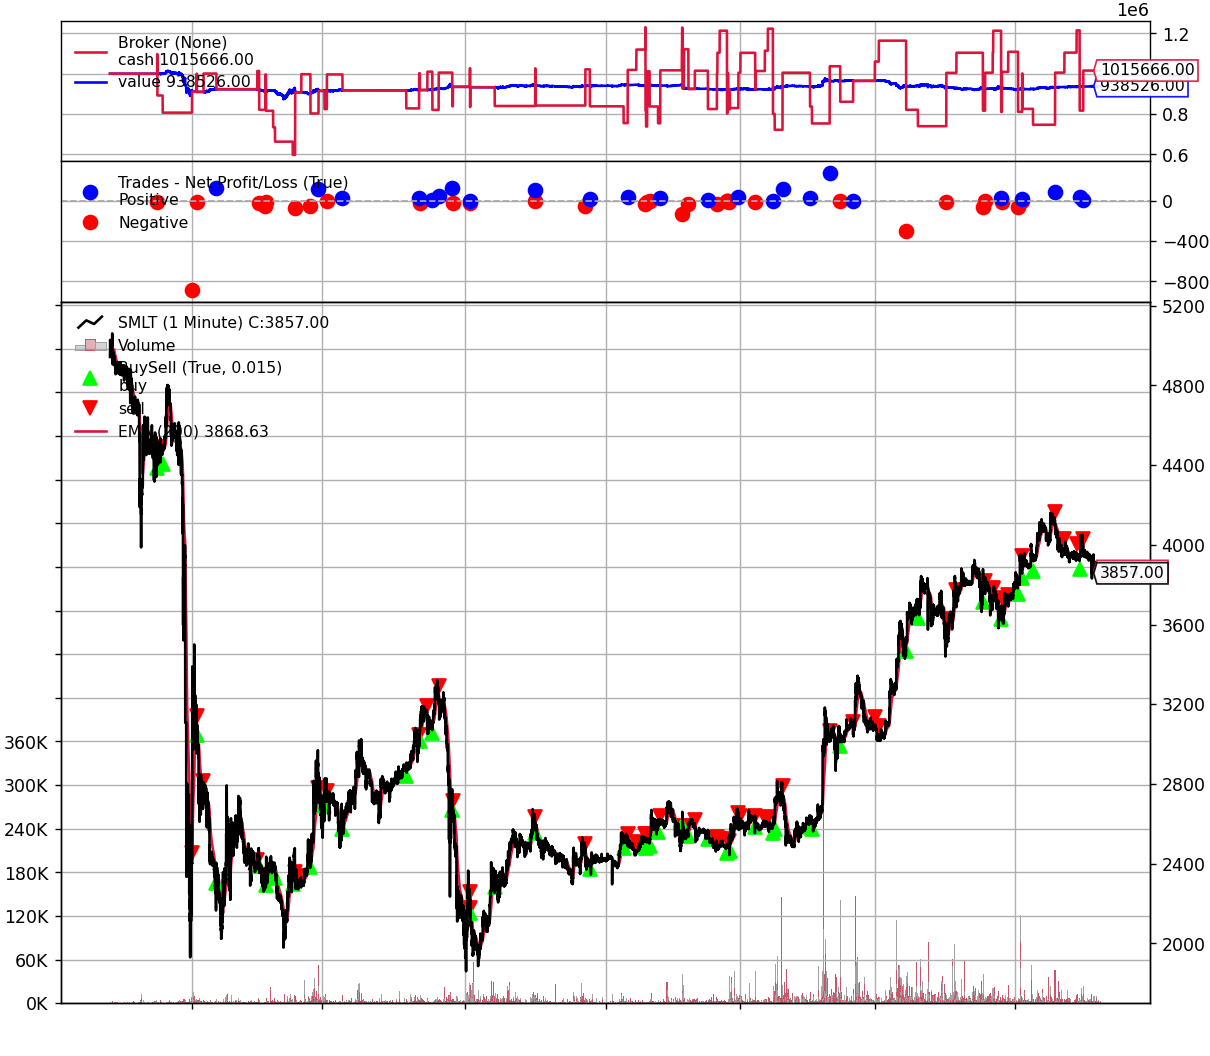

[[<Figure size 640x480 with 4 Axes>]]

In [121]:
cerebro.plot()

In [122]:
cerebro = bt.Cerebro()
cerebro.broker.set_cash(1000000.0)

ticker = 'SBER'
data = MyCSVData(dataname=f'{ticker}.csv')
cerebro.adddata(data)

cerebro.addstrategy(EMA_Breakthrough_v2)

cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe', riskfreerate=0.11)
cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')

thestrats = cerebro.run()
thestrat = thestrats[0]

print('Sharpe Ratio:', thestrat.analyzers.mysharpe.get_analysis())
print('Max drawdown:', thestrat.analyzers.drawdown.get_analysis().max)

item.close[0] / start_price = 1.0171234492193029
item.close[0] / start_price = 0.6941606176892136
item.close[0] / start_price = 1.0584064584064585
item.close[0] / start_price = 0.9420714285714284
item.close[0] / start_price = 1.0161397670549084
item.close[0] / start_price = 0.9874696530660193
item.close[0] / start_price = 0.9877952755905512
Selling 0
2022-05-04 11:15:00 SELL EXECUTED, 126.87 -789
Количество ордеров: 1
item.close[0] / start_price = 0.987879268002852
Closing -789
Buying -789
2022-05-24 14:50:00 BUY EXECUTED, 121.40 789
Количество ордеров: 2
2022-05-24 14:50:00 BUY EXECUTED, 121.40 906
Количество ордеров: 3
Buying 906
2022-06-01 11:05:00 BUY EXECUTED, 120.29 743
Количество ордеров: 4
Closing 1649
Selling 1649
2022-06-02 10:50:00 SELL EXECUTED, 120.17 -1649
Количество ордеров: 5
2022-06-02 10:50:00 SELL EXECUTED, 120.17 -669
Количество ордеров: 6
Closing -669
Buying -669
2022-06-14 11:55:00 BUY EXECUTED, 118.79 669
Количество ордеров: 7
2022-06-14 11:55:00 BUY EXECUTED, 11

<IPython.core.display.Javascript object>


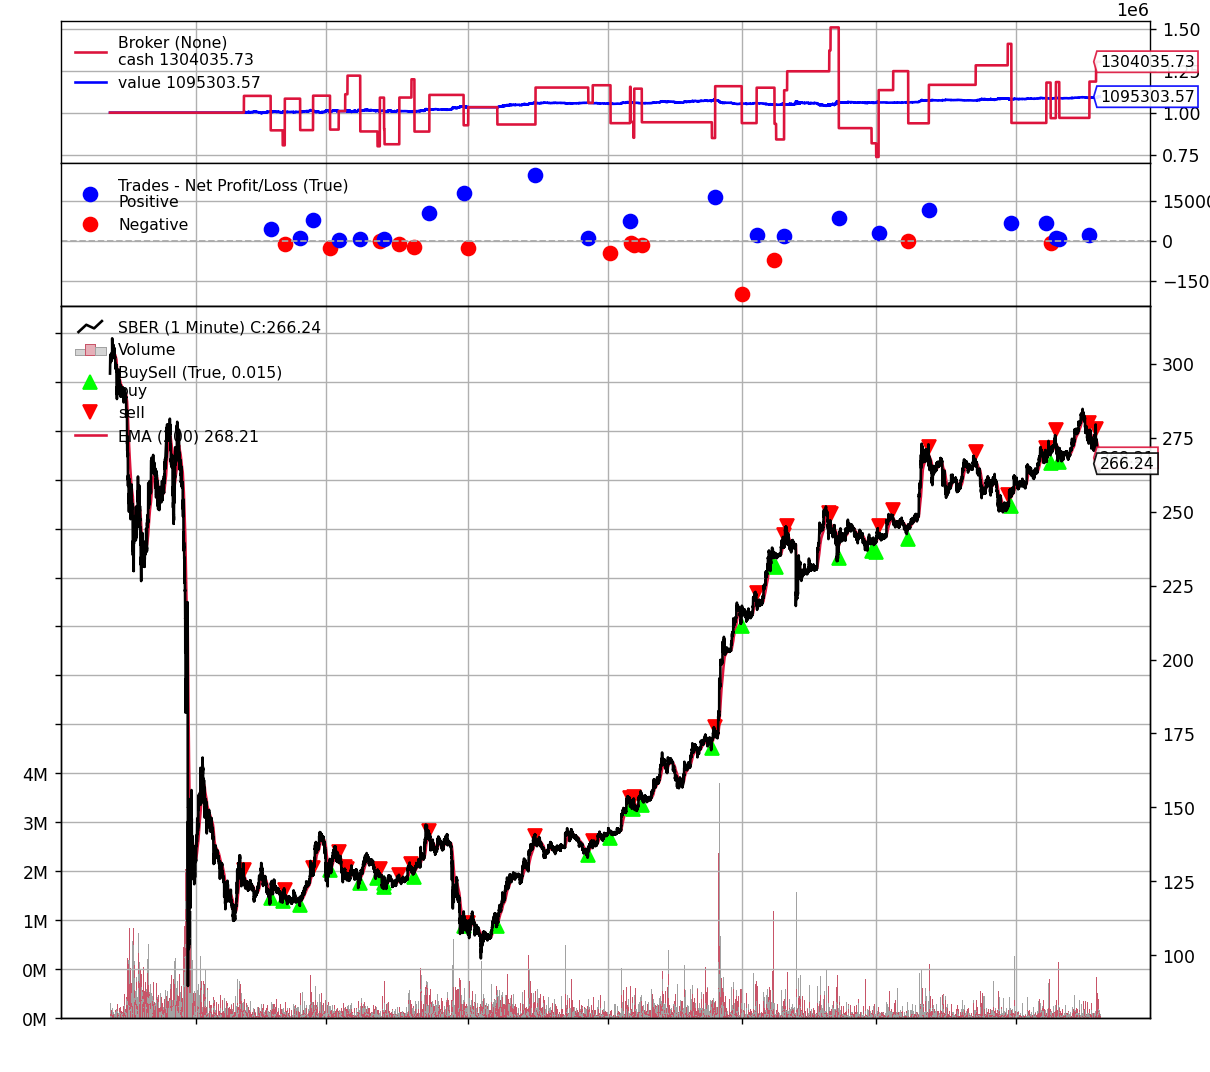

[[<Figure size 640x480 with 4 Axes>]]

In [123]:
cerebro.plot()

In [124]:
cerebro = bt.Cerebro()
cerebro.broker.set_cash(1000000.0)

ticker = 'KZOS'
data = MyCSVData(dataname=f'{ticker}.csv')
cerebro.adddata(data)

cerebro.addstrategy(EMA_Breakthrough_v2)

cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe', riskfreerate=0.11)
cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')

thestrats = cerebro.run()
thestrat = thestrats[0]

print('Sharpe Ratio:', thestrat.analyzers.mysharpe.get_analysis())
print('Max drawdown:', thestrat.analyzers.drawdown.get_analysis().max)

Selling 0
2022-02-16 17:35:00 SELL EXECUTED, 88.50 -1128
Количество ордеров: 1
Closing -1128
Buying -1128
2022-02-18 13:55:00 BUY EXECUTED, 88.70 1128
Количество ордеров: 2
2022-02-18 13:55:00 BUY EXECUTED, 88.70 1248
Количество ордеров: 3
item.close[0] / start_price = 1.0833333333333333
item.close[0] / start_price = 1.0281501340482575
Buying 1248
2022-02-25 17:00:00 BUY EXECUTED, 72.50 1226
Количество ордеров: 4
Buying 2474
2022-02-25 18:35:00 BUY EXECUTED, 72.60 1102
Количество ордеров: 5
Buying 3576
2022-04-20 10:50:00 BUY EXECUTED, 71.30 1011
Количество ордеров: 6
item.close[0] / start_price = 1.0113475177304965
Buying 4587
2022-05-17 10:35:00 BUY EXECUTED, 66.50 976
Количество ордеров: 7
Closing 5563
Selling 5563
2022-05-20 17:35:00 SELL EXECUTED, 72.70 -5563
Количество ордеров: 8
2022-05-20 17:35:00 SELL EXECUTED, 72.70 -804
Количество ордеров: 9
Selling -804
2022-05-23 10:15:00 SELL EXECUTED, 72.00 -1452
Количество ордеров: 10
Closing -2256
item.close[0] / start_price = 1.020618

Buying 838
2023-06-20 17:10:00 BUY EXECUTED, 120.60 688
Количество ордеров: 94
Buying 1526
2023-06-22 13:55:00 BUY EXECUTED, 121.90 615
Количество ордеров: 95
Closing 2141
Selling 2141
2023-07-07 17:55:00 SELL EXECUTED, 114.70 -2141
Количество ордеров: 96
2023-07-07 17:55:00 SELL EXECUTED, 114.70 -588
Количество ордеров: 97
item.close[0] / start_price = 0.952215464813206
Selling -588
2023-07-20 11:50:00 SELL EXECUTED, 111.00 -888
Количество ордеров: 98
Closing -1476
Buying -1476
2023-08-01 16:25:00 BUY EXECUTED, 114.00 1476
Количество ордеров: 99
2023-08-01 16:25:00 BUY EXECUTED, 114.00 953
Количество ордеров: 100
Closing 953
item.close[0] / start_price = 0.9774109470026064
2023-08-04 15:25:00 SELL EXECUTED, 112.80 -953
Количество ордеров: 101
item.close[0] / start_price = 1.032114183764496
Selling 0
2023-08-17 14:30:00 SELL EXECUTED, 111.40 -823
Количество ордеров: 102
Selling -823
2023-08-28 15:45:00 SELL EXECUTED, 112.80 -894
Количество ордеров: 103
Selling -1717
2023-08-31 12:20:00

<IPython.core.display.Javascript object>


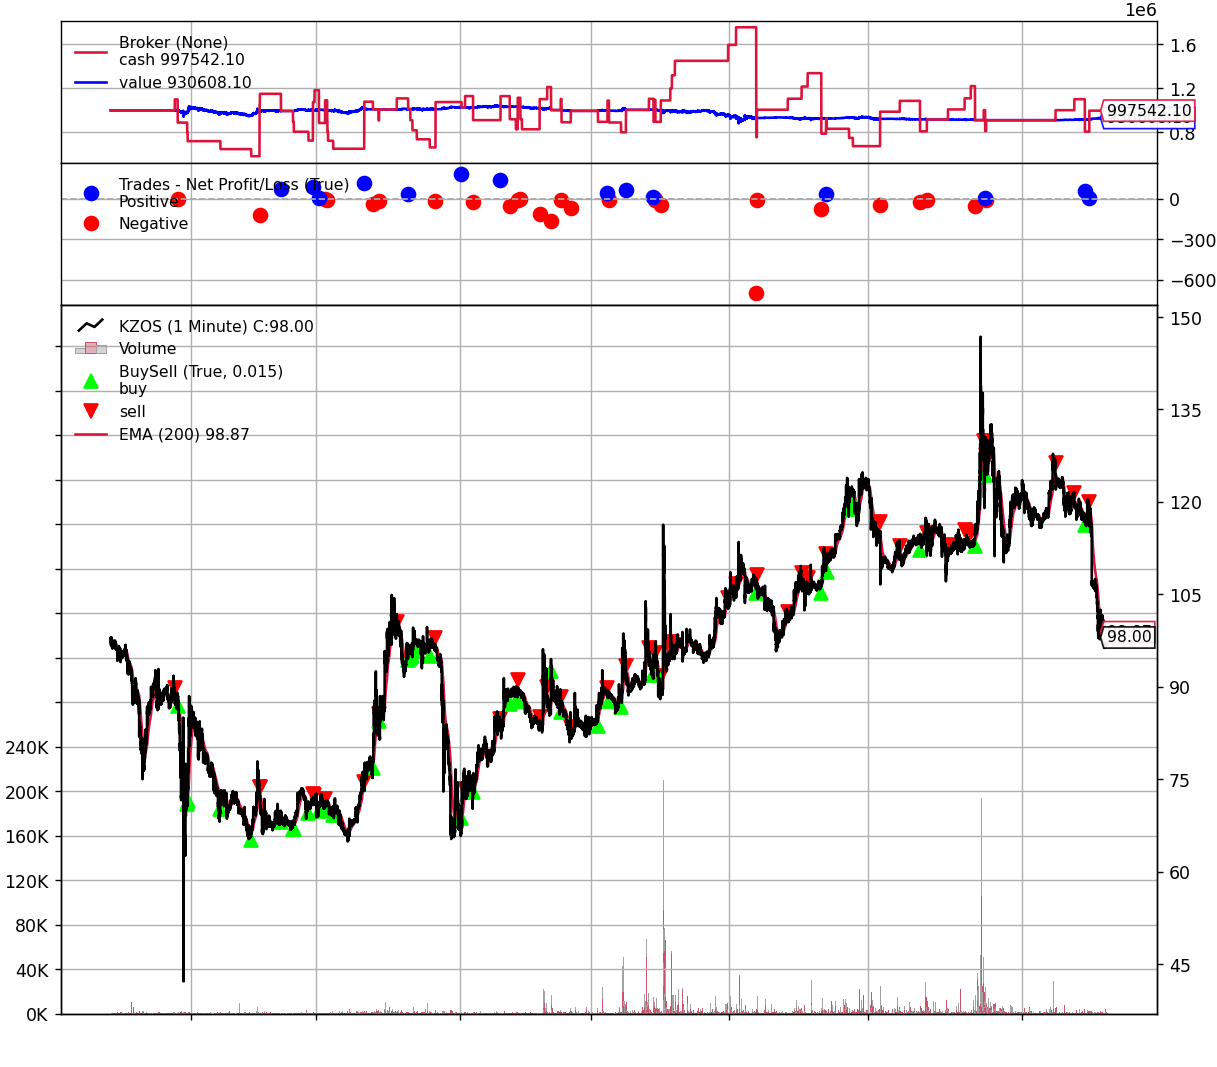

[[<Figure size 640x480 with 4 Axes>]]

In [125]:
cerebro.plot()

In [128]:
class EMA_Breakthrough_v3(bt.Strategy):
    
    def __init__(self):
        self.sma = bt.ind.EMA(period=200)
        self.up_flag = None
        self.wait_flag = False
        self.n_wait = 5
        self.cur_i_candle = 0 
        self.order = None
        self.order_counter = 0
        self.orders_b = []
        self.orders_s = []
        self.quantile = 0.8
        self.quantile_n_vols = 2000
        
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {self.datas[0].datetime.time(0).isoformat()} {txt}') # Comment this line when running optimization
        print('Количество ордеров:', self.order_counter)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        self.order_counter += 1
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, {order.executed.price:.2f} {order.executed.size}')
            elif order.issell():
                self.log(f'SELL EXECUTED, {order.executed.price:.2f} {order.executed.size}')
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None
        
        
    def next(self):
        item = self.datas[0]
        if len(self.orders_b) > self.quantile_n_vols:
            self.orders_b[:-1] = self.orders_b[1:]
            self.orders_b[-1] = item.put_orders_b[0]
            self.orders_s[:-1] = self.orders_s[1:]
            self.orders_s[-1] = item.put_orders_s[0]
        else:
            self.orders_b.append(item.put_orders_b[0])
            self.orders_s.append(item.put_orders_s[0])
            return
        
        if self.wait_flag:
            if (self.up_flag and item.pr_vwap[0] >= self.sma)\
                    or (not self.up_flag and item.pr_vwap[0] < self.sma):
                self.cur_i_candle += 1
            else:
                self.wait_flag = False
                self.up_flag = not self.up_flag
            
            if self.cur_i_candle == self.n_wait:
                
                if self.up_flag:
                    if self.position.size < 0:
                        print('Closing', self.position.size)
                        self.order = self.close()
                    print('Buying', self.position.size)
                    size = math.floor(self.broker.cash / 10 / self.data.close)
                    self.order = self.buy(size=size)
                elif not self.up_flag:
                    if self.position.size > 0:
                        print('Closing', self.position.size)
                        self.order = self.close()
                    print('Selling', self.position.size)
                    size = math.floor(self.broker.cash / 10 / self.data.close)
                    self.order = self.sell(size=size)
                self.wait_flag = False
            

        else:
            if (not self.up_flag and item.pr_vwap[0] >= self.sma) \
                    or (self.up_flag and item.pr_vwap[0] < self.sma):
                self.up_flag = not self.up_flag
                if (self.up_flag and item.put_orders_b[0] - item.put_orders_b[-1] > np.quantile(self.orders_b, self.quantile)) \
                        or (not self.up_flag and item.put_orders_s[0] - item.put_orders_s[-1] > np.quantile(self.orders_s, self.quantile)):
                    self.wait_flag = True
                    start_price = item.close[-1]
                    self.cur_i_candle = 0

In [129]:
cerebro = bt.Cerebro()
cerebro.broker.set_cash(1000000.0)

ticker = 'SMLT'
data = MyCSVData(dataname=f'{ticker}.csv')
cerebro.adddata(data)

cerebro.addstrategy(EMA_Breakthrough_v3)

cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe', riskfreerate=0.11)
cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')

thestrats = cerebro.run()
thestrat = thestrats[0]

print('Sharpe Ratio:', thestrat.analyzers.mysharpe.get_analysis())
print('Max drawdown:', thestrat.analyzers.drawdown.get_analysis().max)

Buying 0
2022-02-03 11:35:00 BUY EXECUTED, 4504.00 22
Количество ордеров: 1
Closing 22
Selling 22
2022-02-17 10:35:00 SELL EXECUTED, 4510.00 -22
Количество ордеров: 2
2022-02-17 10:35:00 SELL EXECUTED, 4510.00 -19
Количество ордеров: 3
Closing -19
Buying -19
2022-02-18 10:55:00 BUY EXECUTED, 4590.00 19
Количество ордеров: 4
2022-02-18 10:55:00 BUY EXECUTED, 4590.00 23
Количество ордеров: 5
Closing 23
Selling 23
2022-04-11 12:25:00 SELL EXECUTED, 2674.00 -23
Количество ордеров: 6
2022-04-11 12:25:00 SELL EXECUTED, 2674.00 -33
Количество ордеров: 7
Closing -33
Buying -33
2022-04-15 11:55:00 BUY EXECUTED, 2355.00 33
Количество ордеров: 8
2022-04-15 11:55:00 BUY EXECUTED, 2355.00 44
Количество ордеров: 9
Buying 44
2022-04-15 15:00:00 BUY EXECUTED, 2372.50 36
Количество ордеров: 10
Closing 80
Selling 80
2022-04-18 11:45:00 SELL EXECUTED, 2269.00 -80
Количество ордеров: 11
2022-04-18 11:45:00 SELL EXECUTED, 2269.00 -34
Количество ордеров: 12
Closing -34
Buying -34
2022-04-25 17:50:00 BUY EXE

Closing 210
Selling 210
2022-11-02 10:35:00 SELL EXECUTED, 2507.50 -210
Количество ордеров: 111
2022-11-02 10:35:00 SELL EXECUTED, 2507.50 -21
Количество ордеров: 112
Selling -21
2022-11-02 14:05:00 SELL EXECUTED, 2514.50 -44
Количество ордеров: 113
Closing -65
Buying -65
2022-11-09 17:30:00 BUY EXECUTED, 2497.00 65
Количество ордеров: 114
2022-11-09 17:30:00 BUY EXECUTED, 2497.00 49
Количество ордеров: 115
Buying 49
2022-11-14 11:35:00 BUY EXECUTED, 2547.00 36
Количество ордеров: 116
Closing 85
Selling 85
2022-11-16 12:45:00 SELL EXECUTED, 2590.00 -85
Количество ордеров: 117
2022-11-16 12:45:00 SELL EXECUTED, 2590.00 -32
Количество ордеров: 118
Selling -32
2022-11-16 17:05:00 SELL EXECUTED, 2564.50 -44
Количество ордеров: 119
Selling -76
2022-11-28 10:35:00 SELL EXECUTED, 2453.50 -51
Количество ордеров: 120
Closing -127
Buying -127
2022-11-28 11:15:00 BUY EXECUTED, 2475.00 127
Количество ордеров: 121
2022-11-28 11:15:00 BUY EXECUTED, 2475.00 56
Количество ордеров: 122
Closing 56
Selli

Closing 33
Selling 33
2023-09-06 10:35:00 SELL EXECUTED, 3842.50 -33
Количество ордеров: 219
2023-09-06 10:35:00 SELL EXECUTED, 3842.50 -27
Количество ордеров: 220
Closing -27
Buying -27
2023-09-12 10:35:00 BUY EXECUTED, 3822.50 27
Количество ордеров: 221
2023-09-12 10:35:00 BUY EXECUTED, 3822.50 33
Количество ордеров: 222
Closing 33
Selling 33
2023-09-13 13:10:00 SELL EXECUTED, 3787.50 -33
Количество ордеров: 223
2023-09-13 13:10:00 SELL EXECUTED, 3787.50 -27
Количество ордеров: 224
Selling -27
2023-10-03 10:35:00 SELL EXECUTED, 3784.50 -33
Количество ордеров: 225
Selling -60
2023-10-09 11:15:00 SELL EXECUTED, 3903.00 -35
Количество ордеров: 226
Selling -95
2023-10-20 10:45:00 SELL EXECUTED, 4049.00 -37
Количество ордеров: 227
Closing -132
Buying -132
2023-10-25 14:45:00 BUY EXECUTED, 4108.50 132
Количество ордеров: 228
2023-10-25 14:45:00 BUY EXECUTED, 4108.50 41
Количество ордеров: 229
Buying 41
2023-10-26 10:35:00 BUY EXECUTED, 4122.50 23
Количество ордеров: 230
Buying 64
2023-11-0

<IPython.core.display.Javascript object>


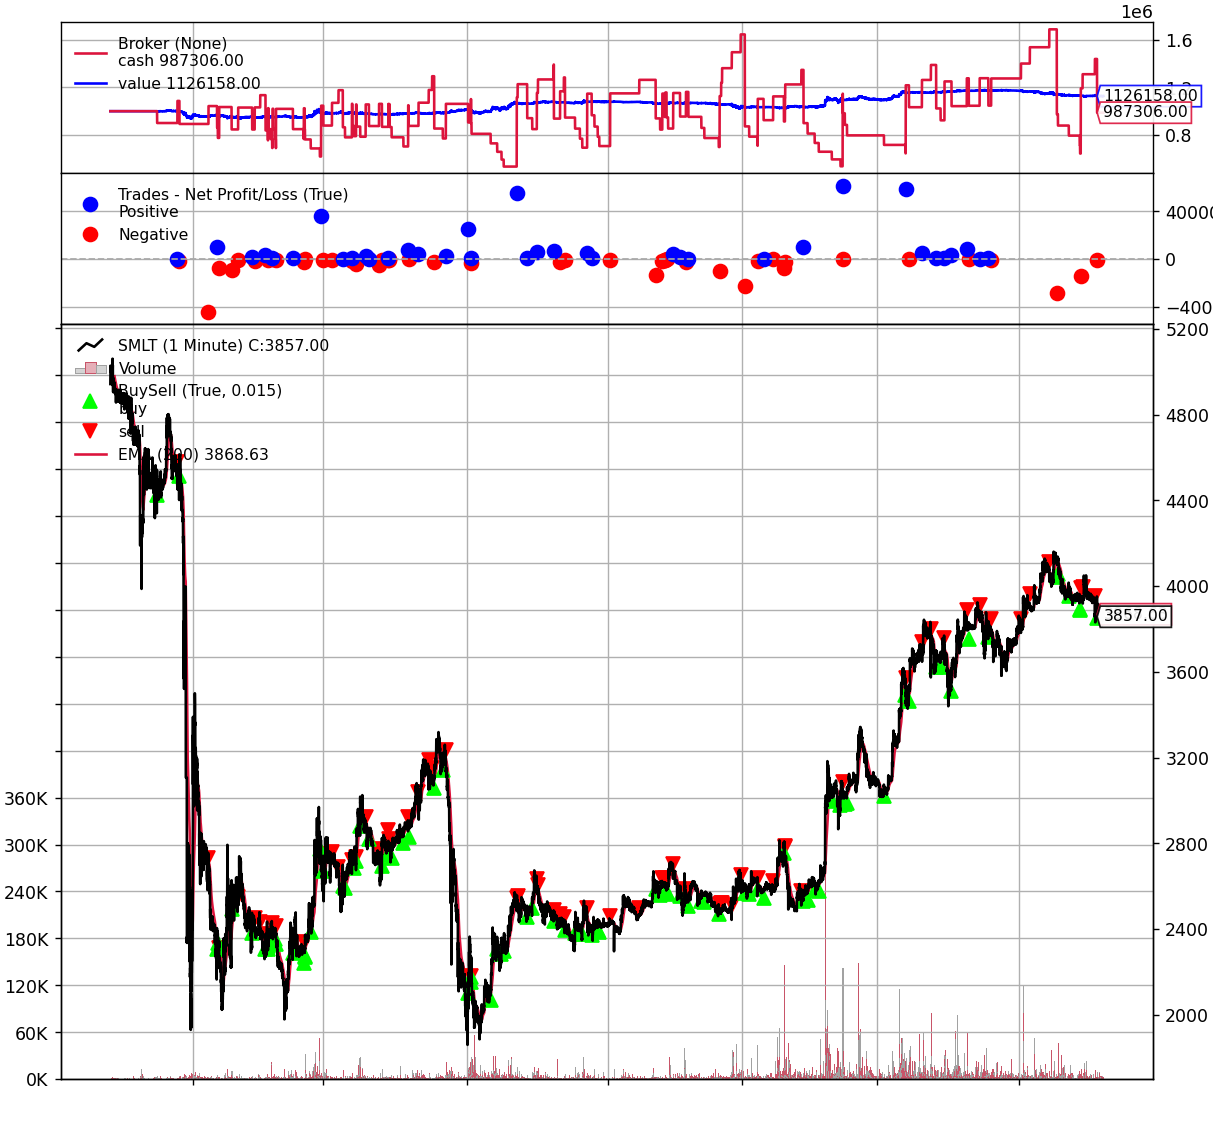

[[<Figure size 640x480 with 4 Axes>]]

In [130]:
cerebro.plot()

In [131]:
cerebro = bt.Cerebro()
cerebro.broker.set_cash(1000000.0)

ticker = 'SBER'
data = MyCSVData(dataname=f'{ticker}.csv')
cerebro.adddata(data)

cerebro.addstrategy(EMA_Breakthrough_v3)

cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe', riskfreerate=0.11)
cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')

thestrats = cerebro.run()
thestrat = thestrats[0]

print('Sharpe Ratio:', thestrat.analyzers.mysharpe.get_analysis())
print('Max drawdown:', thestrat.analyzers.drawdown.get_analysis().max)

Selling 0
2022-02-17 10:35:00 SELL EXECUTED, 268.28 -372
Количество ордеров: 1
Closing -372
Buying -372
2022-02-22 18:20:00 BUY EXECUTED, 215.70 372
Количество ордеров: 2
2022-02-22 18:20:00 BUY EXECUTED, 215.70 510
Количество ордеров: 3
Closing 510
Selling 510
2022-02-24 10:40:00 SELL EXECUTED, 150.14 -510
Количество ордеров: 4
2022-02-24 10:40:00 SELL EXECUTED, 150.14 -605
Количество ордеров: 5
Closing -605
Buying -605
2022-03-24 10:45:00 BUY EXECUTED, 150.76 605
Количество ордеров: 6
2022-03-24 10:45:00 BUY EXECUTED, 150.76 714
Количество ордеров: 7
Closing 714
Selling 714
2022-03-24 12:50:00 SELL EXECUTED, 137.58 -714
Количество ордеров: 8
2022-03-24 12:50:00 SELL EXECUTED, 137.58 -638
Количество ордеров: 9
Closing -638
Buying -638
2022-03-30 10:35:00 BUY EXECUTED, 134.30 638
Количество ордеров: 10
2022-03-30 10:35:00 BUY EXECUTED, 134.30 792
Количество ордеров: 11
Buying 792
2022-05-24 14:50:00 BUY EXECUTED, 121.40 718
Количество ордеров: 12
Closing 1510
Selling 1510
2022-05-26 14

Closing -3889
Buying -3889
2023-01-26 10:35:00 BUY EXECUTED, 152.89 3889
Количество ордеров: 102
2023-01-26 10:35:00 BUY EXECUTED, 152.89 1038
Количество ордеров: 103
Closing 1038
Selling 1038
2023-02-08 14:25:00 SELL EXECUTED, 163.69 -1038
Количество ордеров: 104
2023-02-08 14:25:00 SELL EXECUTED, 163.69 -509
Количество ордеров: 105
Closing -509
Buying -509
2023-02-09 16:40:00 BUY EXECUTED, 166.50 509
Количество ордеров: 106
2023-02-09 16:40:00 BUY EXECUTED, 166.50 652
Количество ордеров: 107
Closing 652
Selling 652
2023-02-13 15:00:00 SELL EXECUTED, 165.42 -652
Количество ордеров: 108
2023-02-13 15:00:00 SELL EXECUTED, 165.42 -540
Количество ордеров: 109
Selling -540
2023-02-20 10:35:00 SELL EXECUTED, 158.75 -687
Количество ордеров: 110
Closing -1227
Buying -1227
2023-03-03 11:50:00 BUY EXECUTED, 169.39 1227
Количество ордеров: 111
2023-03-03 11:50:00 BUY EXECUTED, 169.39 708
Количество ордеров: 112
Closing 708
Selling 708
2023-03-10 10:35:00 SELL EXECUTED, 170.65 -708
Количество орд

<IPython.core.display.Javascript object>


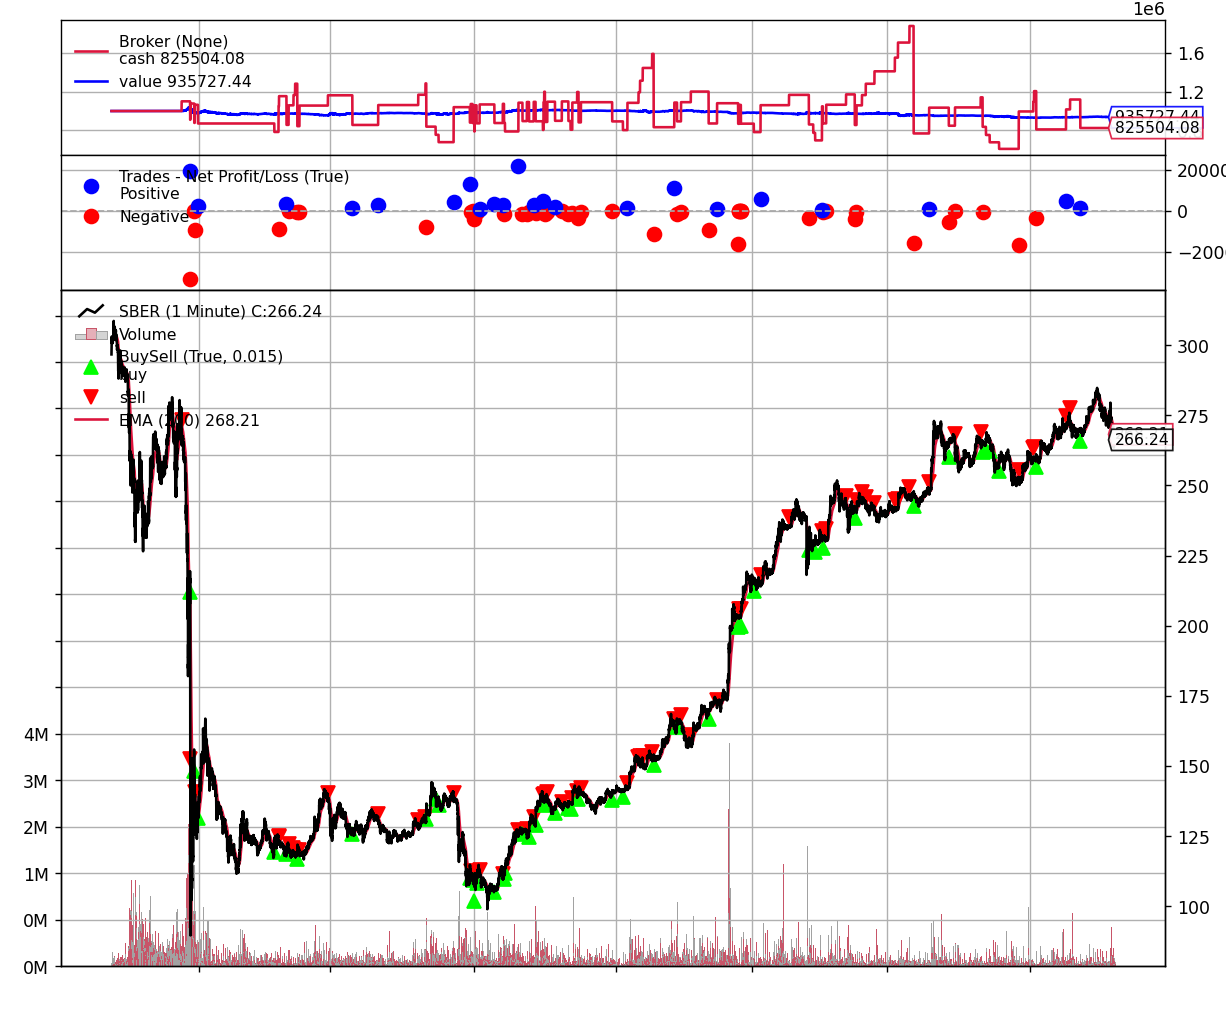

[[<Figure size 640x480 with 4 Axes>]]

In [132]:
cerebro.plot()

In [133]:
cerebro = bt.Cerebro()
cerebro.broker.set_cash(1000000.0)

ticker = 'KZOS'
data = MyCSVData(dataname=f'{ticker}.csv')
cerebro.adddata(data)

cerebro.addstrategy(EMA_Breakthrough_v3)

cerebro.addanalyzer(btanalyzers.SharpeRatio, _name='mysharpe', riskfreerate=0.11)
cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')

thestrats = cerebro.run()
thestrat = thestrats[0]

print('Sharpe Ratio:', thestrat.analyzers.mysharpe.get_analysis())
print('Max drawdown:', thestrat.analyzers.drawdown.get_analysis().max)

Buying 0
2022-02-09 10:40:00 BUY EXECUTED, 89.10 1122
Количество ордеров: 1
Buying 1122
2022-02-16 13:20:00 BUY EXECUTED, 90.90 991
Количество ордеров: 2
Closing 2113
Selling 2113
2022-02-17 10:35:00 SELL EXECUTED, 87.80 -2113
Количество ордеров: 3
2022-02-17 10:35:00 SELL EXECUTED, 87.80 -922
Количество ордеров: 4
Closing -922
Buying -922
2022-02-22 18:10:00 BUY EXECUTED, 84.50 922
Количество ордеров: 5
2022-02-22 18:10:00 BUY EXECUTED, 84.50 1273
Количество ордеров: 6
Buying 1273
2022-04-21 12:10:00 BUY EXECUTED, 72.40 1227
Количество ордеров: 7
Closing 2500
Selling 2500
2022-04-22 12:35:00 SELL EXECUTED, 71.70 -2500
Количество ордеров: 8
2022-04-22 12:35:00 SELL EXECUTED, 71.70 -1115
Количество ордеров: 9
Selling -1115
2022-05-12 11:35:00 SELL EXECUTED, 68.30 -1553
Количество ордеров: 10
Closing -2668
Buying -2668
2022-05-17 12:20:00 BUY EXECUTED, 66.80 2668
Количество ордеров: 11
2022-05-17 12:20:00 BUY EXECUTED, 66.80 1752
Количество ордеров: 12
Closing 1752
Selling 1752
2022-05-2

Buying 1938
2023-02-24 11:35:00 BUY EXECUTED, 96.60 821
Количество ордеров: 109
Buying 2759
2023-02-27 11:35:00 BUY EXECUTED, 95.80 744
Количество ордеров: 110
Buying 3503
2023-03-02 12:55:00 BUY EXECUTED, 97.50 659
Количество ордеров: 111
Closing 4162
Selling 4162
2023-03-02 13:30:00 SELL EXECUTED, 94.20 -4162
Количество ордеров: 112
2023-03-02 13:30:00 SELL EXECUTED, 94.20 -613
Количество ордеров: 113
Closing -613
Buying -613
2023-03-06 10:35:00 BUY EXECUTED, 98.80 613
Количество ордеров: 114
2023-03-06 10:35:00 BUY EXECUTED, 98.80 1041
Количество ордеров: 115
Buying 1041
2023-03-14 17:55:00 BUY EXECUTED, 96.60 897
Количество ордеров: 116
Closing 1938
Selling 1938
2023-03-28 11:05:00 SELL EXECUTED, 101.20 -1938
Количество ордеров: 117
2023-03-28 11:05:00 SELL EXECUTED, 101.20 -769
Количество ордеров: 118
Closing -769
Buying -769
2023-03-29 17:10:00 BUY EXECUTED, 101.80 769
Количество ордеров: 119
2023-03-29 17:10:00 BUY EXECUTED, 101.80 1036
Количество ордеров: 120
Closing 1036
Selli

<IPython.core.display.Javascript object>


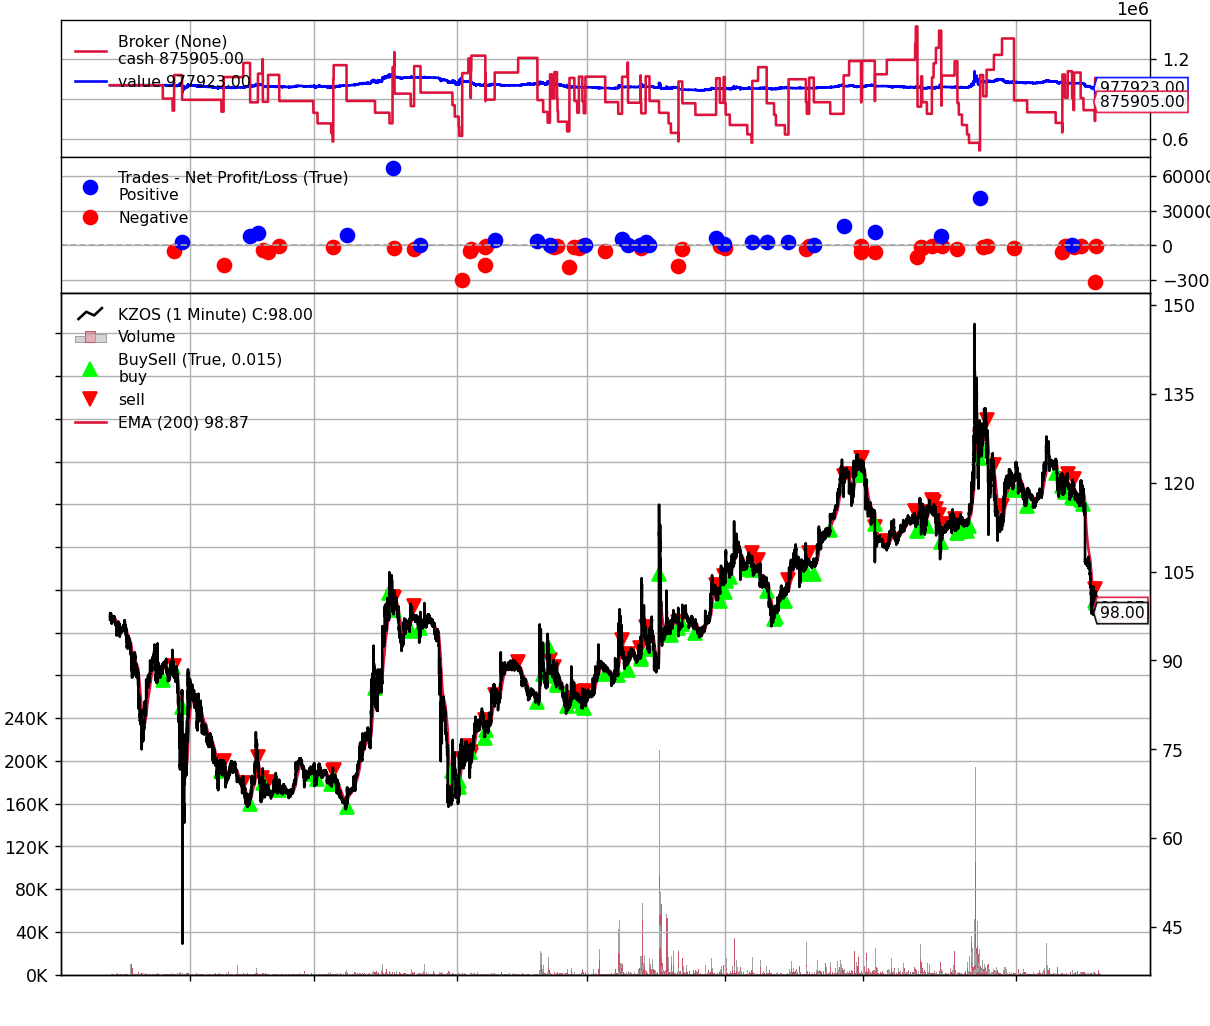

[[<Figure size 640x480 with 4 Axes>]]

In [134]:
cerebro.plot()